In [4]:
import os
import pandas as pd
import ROOT as r
from datetime import datetime
import matplotlib.pyplot as plt

Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<std::vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 
Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 


Welcome to JupyROOT 6.24/07


In [6]:
class lumiDict:
    
    def __init__(self):
        
        self.run = -1
        self.file = -1
        self.lumis = None
        self.fill = None
        self.beam = None
        self.dir = None
        self.filename = None
        self.start = None
        self.stop = None
    

In [16]:
class mqLumiList():
    
    def __init__(self):
        self.lumi_csv = ''
        self.rawPath = '/store/user/milliqan/run3/'
        self.mqLumis = pd.DataFrame(columns=['run', 'file', 'lumis', 'fill', 'beam', 'dir', 'filename', 'start', 'stop'])
        self.debug = False
        
    def looper(self):
        #rawDirectories = ['1000', '1100']
        #rawSubDirectories = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009']
        rawDirectories = ['1100']
        rawSubDirectories = ['0009']

        for i, d1 in enumerate(rawDirectories):
            for j, d2 in enumerate(rawSubDirectories):
                if self.debug and j > 0: return
                if not os.path.exists(self.rawPath+'/'+d1+'/'+d2): continue
                self.initializeDataframe('{0}/{1}'.format(d1, d2))
                self.setFileTimes()
                self.setMQLumis()
                if not self.debug: self.saveJson()

                
    def initializeDataframe(self, path):
        fileCnt = 0
        for ifile, filename in enumerate(os.listdir(self.rawPath+'/'+path)):
            if self.debug and fileCnt > 100: 
                return
            if not filename.startswith("MilliQan"): continue
            if fileCnt % 1000 == 0: print("Working on processing file {}".format(fileCnt))
            runNum_, fileNum_ = self.getRunFile(filename)
            #if int(runNum_) != 1006: continue #temp
            #if int(fileNum_) > 190 or int(fileNum_) < 180: continue #temp
            dict_ = lumiDict()
            dict_.run = int(runNum_)
            dict_.file = (fileNum_)
            dict_.dir = self.rawPath+'/'+path
            dict_.filename = filename
            self.mqLumis.loc[len(self.mqLumis.index)] = dict_.__dict__
            fileCnt += 1
                    
                        
    def getRunFile(self, filename):
        runNum = filename.split('Run')[-1].split('.')[0]
        fileNum = filename.split('.')[1].split('_')[0]
        return runNum, fileNum
        
    def openLumis(self):
        self.lumiList = pd.read_csv('Run3Lumis.csv')

    def convertDatetime(self, time):
        dt_ = datetime.strptime(time, '%Y-%m-%d_%Hh%Mm%Ss')
        return dt_   

    def getFileTime(self, file):
        try:
            myfile = r.TFile.Open(file)
        except:
            print("File {} is a zombie, skipping...".format(file))
            return pd.NaT, pd.NaT
        meta = myfile.Get('Metadata')
        t_open = -1
        t_close = -1
        for event in meta:
            t_open = event.fileOpenTime
            t_close = event.fileCloseTime
        d_open = self.convertDatetime(str(t_open))
        d_close = self.convertDatetime(str(t_close))
        return d_open, d_close
        
    def setFileTimes(self):
        self.mqLumis[['start', 'stop']] = self.mqLumis.apply(lambda x: self.getFileTime(x.dir + '/' + x.filename) if pd.isnull(x.start) else (x.start, x.stop), axis='columns', result_type='expand')
        
    def addDatetimes(self):
        self.lumiList['start_time'] = self.lumiList['start_time'].where(pd.notnull(self.lumiList['start_time']), None)
        self.lumiList['end_time'] = self.lumiList['end_time'].where(pd.notnull(self.lumiList['end_time']), None)

        self.lumiList['start_time'] = self.lumiList['start_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList['end_time'] = self.lumiList['end_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if x != None else x)
        self.lumiList = self.lumiList.sort_values(by=['start_time'])
        self.lumiList = self.lumiList.reset_index(drop=True)
        
    def findLumiStart(self, start, stop):
    
        startId = -1
        stopId = -1

        #special case for zombie files (maybe better way than letting it get this far?)
        if pd.isnull(start) or pd.isnull(stop):
            mqLumi = 0
            fillId = None 
            beamType = None 
            beamEnergy = None
            betaStar = None 
            beamOn = False 
            fillStart = None 
            fillEnd = None
            return mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd
        
        #if milliqan run starts after all runs in lumi list
        if start > self.lumiList.start_time.max():
            mqLumi = 0
            fillId = None 
            beamType = None 
            beamEnergy = None
            betaStar = None 
            beamOn = False 
            fillStart = None 
            fillEnd = None
            return mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd
        
        for i, st in enumerate(self.lumiList.start_time):
            if start < st: 
                startId = i-1
                break
        for i, (st, et) in enumerate(zip(self.lumiList.end_time[startId:], self.lumiList.start_time[startId:])):
            if stop < st: 
                stopId = startId + i
                break
            elif stop < et:
                stopId = startId + i
                break
        
        #if last milliqan run stops after last LHC run
        if stop > self.lumiList.end_time.max():
            stopId = len(self.lumiList)-1
                
        if startId == stopId:
            fillId = self.lumiList['fill_number'][startId]
            beamType = self.lumiList['fill_type_runtime'][startId]
            beamEnergy = self.lumiList['energy'][startId]
            betaStar = self.lumiList['beta_star'][startId]
            fillStart = self.lumiList['start_time'][startId]
            fillEnd = self.lumiList['end_time'][stopId]
            beamOn = False
            if not pd.isna(self.lumiList['start_stable_beam'][startId]):
                beamOn = True
            
            mqLumi = 0
            if beamOn:
                totalLumi = self.lumiList['delivered_lumi'][startId]
                totalFillTime = self.lumiList['duration'][startId]
                totalMQTime = (stop-start).total_seconds()
                #print(totalLumi, totalFillTime, totalMQTime)
                frac = totalMQTime / totalFillTime
                mqLumi = totalLumi * frac
                
        else:
            print("ids", startId, stopId)
            print("start fill {0}, stop fill {1}".format(self.lumiList['fill_number'][startId], self.lumiList['fill_number'][stopId]))
            fillId = self.lumiList['fill_number'][startId:stopId+1].to_list()
            beamType = self.lumiList['fill_type_runtime'][startId:stopId+1].to_list()
            beamEnergy = self.lumiList['energy'][startId:stopId+1].to_list()
            betaStar = self.lumiList['beta_star'][startId:stopId+1].to_list()
            beamOn = [False if pd.isna(x) else True for x in self.lumiList['start_stable_beam'][startId:stopId+1]]
            fillStart = self.lumiList['start_time'][startId]
            fillEnd = self.lumiList['end_time'][stopId]
            mqLumi = 0
            for i in range(startId, stopId+1):
                x = self.lumiList[['start_time', 'end_time', 'delivered_lumi', 'duration', 'fill_number']].iloc[i]
                print("checking fill", x.fill_number)
                if pd.isna(x.delivered_lumi): continue
                if start < x.start_time: #milliqan run starts before fill
                    if stop >= x.end_time: #milliqan run spans entire fill
                        mqLumi += x.delivered_lumi
                    elif stop < x.end_time: #milliqan run stops before end of fill
                        total_time = (stop - x.start_time).total_seconds()
                        frac = total_time / x.duration
                        mqLumi += frac * x.delivered_lumi
                elif start > x.start_time: #milliqan run starts after fill
                    if stop >= x.end_time: #milliqan run ends after fill
                        total_time = (x.end_time - start).total_seconds()
                        frac = total_time / x.duration
                        mqLumi += frac * x.delivered_lumi
                    elif stop < x.end_time: #milliqan run ends before fill
                        print("This should be handled already!")
                else:
                    print("Bug in code, this case isn't handled")
            
        #print(mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd)
        
        return mqLumi, fillId, beamType, beamEnergy, betaStar, beamOn, fillStart, fillEnd
    
    def setMQLumis(self):
        self.mqLumis[['lumis', 'fill', 'beamType', 'beamEnergy', 'betaStar', 'beam', 'fillStart', 'fillEnd']] = self.mqLumis.apply(lambda x: self.findLumiStart(x.start, x.stop) if x.lumis is None else (x.lumis, x.fill, x.beamType, x.beamEnergy, x.betaStar, x.beam, x.fillStart, x.fillEnd), axis='columns', result_type='expand')

    def saveJson(self):
        self.mqLumis.to_json('mqLumisDebug.json', orient = 'split', compression = 'infer', index = 'true')
                
 

In [25]:
if __name__ == "__main__":
    mylumiList = mqLumiList()
    mylumiList.debug = False
    mylumiList.openLumis()
    mylumiList.addDatetimes()
    mylumiList.looper()

    

Working on processing file 0
ids 1279 1280
start fill 9199, stop fill 9200
checking fill 9199
checking fill 9200
ids 1280 1281
start fill 9200, stop fill 9201
checking fill 9200
checking fill 9201
ids 1275 1276
start fill 9195, stop fill 9196
checking fill 9195
checking fill 9196
ids 1276 1277
start fill 9196, stop fill 9197
checking fill 9196
checking fill 9197
ids 1277 1278
start fill 9197, stop fill 9198
checking fill 9197
checking fill 9198
ids 1278 1279
start fill 9198, stop fill 9199
checking fill 9198
checking fill 9199
ids 1284 1285
start fill 9204, stop fill 9205
checking fill 9204
checking fill 9205
ids 1285 1286
start fill 9205, stop fill 9206
checking fill 9205
checking fill 9206
ids 1286 1288
start fill 9206, stop fill 9208
checking fill 9206
checking fill 9207
checking fill 9208
Start time of milliqan run is after all lumis in file
Start time of milliqan run is after all lumis in file
Start time of milliqan run is after all lumis in file
Start time of milliqan run is afte

In [ ]:
pd.set_option('display.max_rows', None)
mylumiList.lumiList = mylumiList.lumiList.reset_index(drop=True)
display(mylumiList.lumiList)

In [ ]:
mylumiList.lumiList.loc[mylumiList.lumiList['fill_number'] == 9075]

In [13]:
print(len(mylumiList.lumiList))
mylumiList.lumiList.iloc[1286:]

1289


,fill_number,first_run_number,last_run_number,duration,start_time,end_time,start_stable_beam,end_stable_beam,end_time.1,delivered_lumi,recorded_lumi,downtime,efficiency_lumi,peak_lumi,peak_pileup,fill_type_runtime,bunches_target,beta_star,energy,injection_scheme
1286,9206,374409.0,374454.0,7366.0,2023-09-29 03:20:33,2023-09-29 12:23:42,2023-09-29 05:27:29,2023-09-29 07:30:15,2023-09-29 12:23:42,0.000012,0.000011,57,96.888,0.000002,0.000426,IONS,746.0,50.0,6799.32,50ns_451b_394_394_161_56bpi_11inj_3INDIV_PbPb
1287,9207,NaN,NaN,NaN,2023-09-29 12:23:42,2023-09-29 12:24:43,NaN,NaN,2023-09-29 12:24:43,NaN,NaN,0,NaN,NaN,NaN,IONS,746.0,NaN,NaN,50ns_867b_746_746_341_56bpi_23inj_3INDIV_PbPb
1288,9208,374456.0,374505.0,NaN,2023-09-29 12:24:43,NaT,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,IONS,746.0,NaN,NaN,50ns_867b_746_746_341_56bpi_23inj_3INDIV_PbPb


In [3]:
pd.set_option('display.max_rows', None)
mylumiList.mqLumis = mylumiList.mqLumis.sort_values(by=['start'])
mylumiList.mqLumis

NameError: name 'pd' is not defined

In [ ]:
mylumiList.mqLumis.loc[pd.isnull(mylumiList.mqLumis['start'])]

In [ ]:
pd.isna(mylumiList.lumiList['start_stable_beam'].loc[mylumiList.lumiList['fill_number'] == 8862])

In [6]:
import json
fin = open('mqLumis.json')
data = json.load(fin)
lumis = pd.DataFrame(data['data'], columns=data['columns'])
lumis = lumis.sort_values(by=['start'])

In [9]:
lumis

,run,file,lumis,fill,beam,dir,filename,start,stop,beamType,beamEnergy,betaStar,fillStart,fillEnd
0,1000,1,2.960875e-01,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.1_default.root,1.685641e+12,1.685641e+12,PROTONS,6799.56,120.0,1.685618e+12,1.685647e+12
1,1000,2,3.070537e-01,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.2_default.root,1.685641e+12,1.685641e+12,PROTONS,6799.56,120.0,1.685618e+12,1.685647e+12
2,1000,3,2.631889e-01,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.3_default.root,1.685641e+12,1.685641e+12,PROTONS,6799.56,120.0,1.685618e+12,1.685647e+12
3,1000,4,2.631889e-01,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.4_default.root,1.685641e+12,1.685641e+12,PROTONS,6799.56,120.0,1.685618e+12,1.685647e+12
4,1000,5,2.631889e-01,8858,True,/store/user/milliqan/run3//1000/0000,MilliQan_Run1000.5_default.root,1.685641e+12,1.685641e+12,PROTONS,6799.56,120.0,1.685618e+12,1.685647e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25782,1189,76,2.536000e-07,"[9194, 9195]","[True, False]",/store/user/milliqan/run3//1100/0008,MilliQan_Run1189.76_default.root,1.695819e+12,1.695820e+12,"[IONS, IONS]","[6799.32, None]","[50.0, None]",1.695798e+12,1.695829e+12
25783,1189,77,0.000000e+00,9195,False,/store/user/milliqan/run3//1100/0008,MilliQan_Run1189.77_default.root,1.695820e+12,1.695820e+12,IONS,None,None,1.695820e+12,1.695829e+12
25784,1189,78,0.000000e+00,9195,False,/store/user/milliqan/run3//1100/0008,MilliQan_Run1189.78_default.root,1.695820e+12,1.695820e+12,IONS,None,None,1.695820e+12,1.695829e+12
14353,1150,113,0.000000e+00,None,False,/store/user/milliqan/run3//1100/0005,MilliQan_Run1150.113_default.root,NaN,NaN,None,None,None,NaN,NaN


Text(5000, 30000, '32903.28$pb ^{-1}$')

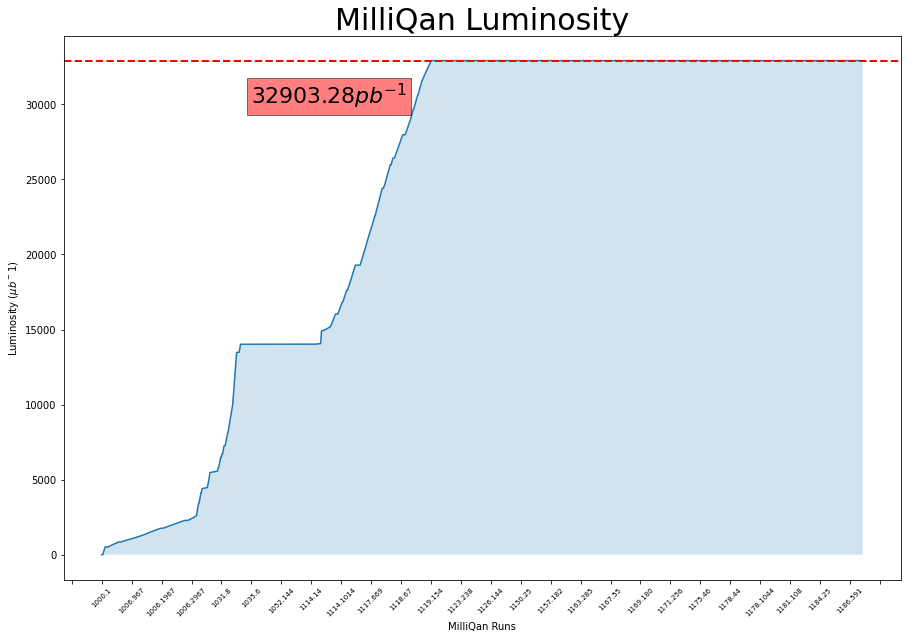

In [24]:
total_lumi = lumis['lumis'].sum()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

#x_vals = lumis[['run', 'file']].apply(lambda x: str(x.run) + '.' + str(x.file), axis=1)[:5000]
#y_vals = lumis[['lumis', 'run', 'file']].notnull().cumsum()[:5000]
cleaned = lumis[~lumis['lumis'].isnull()]
y_vals = cleaned['lumis'].cumsum()
x_vals = cleaned[['run', 'file']].apply(lambda x: str(x.run) + '.' + str(x.file), axis=1)

ax.plot(x_vals, y_vals)
ax.fill_between(x_vals, y_vals, 0, alpha=0.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xlabel("MilliQan Runs")
ax.set_ylabel(r"Luminosity $(\mu b^-1)$")
plt.xticks(rotation=45, fontsize=7)
plt.title("MilliQan Luminosity", fontsize=30)
plt. axhline(y=total_lumi, color='r', linestyle='--', linewidth=2)
plt.text(5000, 30000, str(round(total_lumi, 2))+'$pb ^{-1}$', fontsize=22, bbox=dict(facecolor='red', alpha=0.5))

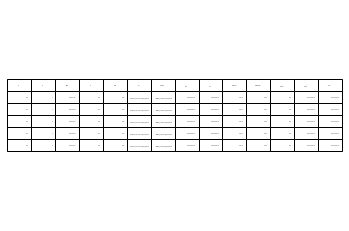

In [8]:
fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=lumis[:5].values, colLabels=lumis[5:].columns, loc='center')
plt.show()